# import packages

In [376]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo 

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, roc_auc_score
)

try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

import joblib

In [377]:
MODELS_DIR = "./models/"
DATA_DIR = "./dataset/"

In [378]:
# fetch dataset 
ai4i_2020_predictive_maintenance_dataset = fetch_ucirepo(id=601) 
  
# data (as pandas dataframes) 
X = ai4i_2020_predictive_maintenance_dataset.data.features.copy()
y = ai4i_2020_predictive_maintenance_dataset.data.targets.copy()
  
# metadata 
print(ai4i_2020_predictive_maintenance_dataset.metadata) 
  
# variable information 
print(ai4i_2020_predictive_maintenance_dataset.variables) 


{'uci_id': 601, 'name': 'AI4I 2020 Predictive Maintenance Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/601/data.csv', 'abstract': 'The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.', 'area': 'Computer Science', 'tasks': ['Classification', 'Regression', 'Causal-Discovery'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 10000, 'num_features': 6, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 'index_col': ['UID', 'Product ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5HS5C', 'creators': [], 'intro_paper': {'ID': 386, 'type': 'NATIVE', 'title': 'Explainable Artificial Intelligen

In [379]:
display(X.head())
display(y.head())

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
0,M,298.1,308.6,1551,42.8,0
1,L,298.2,308.7,1408,46.3,3
2,L,298.1,308.5,1498,49.4,5
3,L,298.2,308.6,1433,39.5,7
4,L,298.2,308.7,1408,40.0,9


,Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


| Feature                   | Sensor Type                  | Description                                                        | Role in Failure Prediction                      |
| ------------------------- | ---------------------------- | ------------------------------------------------------------------ | ----------------------------------------------- |
| `Type`                    | Categorical (Machine Design) | Type of machine (Low performance, Medium, High power/heavy-duty)   | Contextual — sets baseline behavior             |
| `Air temperature [K]`     | Environmental Sensor         | Temperature of the ambient air surrounding the machine             | Affects cooling and ambient thermal conditions  |
| `Process temperature [K]` | Internal Sensor              | Temperature within the system at a critical measurement point      | Critical for detecting overheating, HDF         |
| `Rotational speed [rpm]`  | Kinematic Sensor             | Speed of rotating components, such as motors, gears, or spindles   | Linked to wear, overstrain, and power anomalies |
| `Torque [Nm]`             | Force Sensor                 | Rotational force applied by or to the system                       | Indicates load, tool condition, possible OSF    |
| `Tool wear [min]`         | Operational Timer            | Cumulative operation time for the tool in minutes                  | Strong predictor of end-of-life and TWF         |


| Abbreviation | Failure Type             | Description                                       |
| ------------ | ------------------------ | ------------------------------------------------- |
| `TWF`        | Tool Wear Failure        | Failure due to tool degradation beyond limit      |
| `HDF`        | Heat Dissipation Failure | Inadequate heat transfer, causing overheating     |
| `PWF`        | Power Failure            | Electrical/power supply failure                   |
| `OSF`        | Overstrain Failure       | Component failure due to excessive load or torque |
| `RNF`        | Random Failures          | Other unclassified or spontaneous failures        |

# Data Cleaning & Feature Engineering

In [380]:
df = X.copy()

# Encode 'Type'
type_labeler = LabelEncoder()
df['Type'] = type_labeler.fit_transform(df['Type'])

# Create temperature delta
temp_delta = df['Process temperature'] - df['Air temperature']
df['Temp_Delta'] = temp_delta

df = pd.merge(df, y, left_index=True, right_index=True, how='left')
display(df.head())


,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Temp_Delta,Machine failure,TWF,HDF,PWF,OSF,RNF
0,2,298.1,308.6,1551,42.8,0,10.5,0,0,0,0,0,0
1,1,298.2,308.7,1408,46.3,3,10.5,0,0,0,0,0,0
2,1,298.1,308.5,1498,49.4,5,10.4,0,0,0,0,0,0
3,1,298.2,308.6,1433,39.5,7,10.4,0,0,0,0,0,0
4,1,298.2,308.7,1408,40.0,9,10.5,0,0,0,0,0,0


In [381]:
# Normalize failure type into a single multiclass label
# Two common formats:
#  A) Single column 'Failure Type' (string / int codes)
#  B) Several binary columns (TWF, HDF, PWF, OSF, RNF) per row

if any(col.upper() in ['TWF','HDF','PWF','OSF','RNF'] for col in df.columns):
    # If explicit columns exist, convert to single label
    failure_cols = [c for c in df.columns if c.upper() in ['TWF','HDF','PWF','OSF','RNF']]
    def pick_failure(row):
        for c in failure_cols:
            if int(row[c]) == 1:
                return c.upper()
        return 'NONE'  # no failure recorded
    df['failure_type'] = df.apply(pick_failure, axis=1)
elif 'Machine failure' in df.columns:
    # sometimes 'Machine failure' is 0/1 (binary) and there's also 'failure_type' elsewhere
    if 'failure_type' in df.columns:
        pass
    else:
        df['failure_type'] = df['Machine failure'].astype(str)
else:
    # Fallback: look for a column named 'Type' (but that can be machine type 'L/M/H')
    if 'failure_type' not in df.columns:
        raise ValueError("Couldn't find failure type column automatically. Please set df['failure_type'] manually.")
    
display(df.head())

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Temp_Delta,Machine failure,TWF,HDF,PWF,OSF,RNF,failure_type
0,2,298.1,308.6,1551,42.8,0,10.5,0,0,0,0,0,0,NONE
1,1,298.2,308.7,1408,46.3,3,10.5,0,0,0,0,0,0,NONE
2,1,298.1,308.5,1498,49.4,5,10.4,0,0,0,0,0,0,NONE
3,1,298.2,308.6,1433,39.5,7,10.4,0,0,0,0,0,0,NONE
4,1,298.2,308.7,1408,40.0,9,10.5,0,0,0,0,0,0,NONE


# Exploratory Data Analysis

Text(0.5, 1.0, 'Machine Failure Distribution')

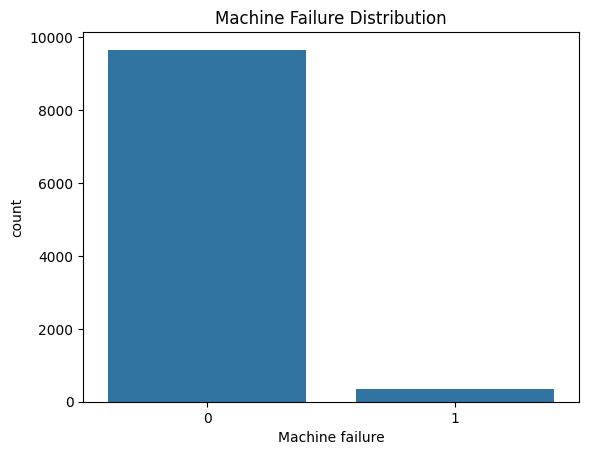

In [382]:
sns.countplot(data=df, x='Machine failure')
plt.title("Machine Failure Distribution")

failure_type
NONE    9652
HDF      115
PWF       91
OSF       78
TWF       46
RNF       18
Name: count, dtype: int64


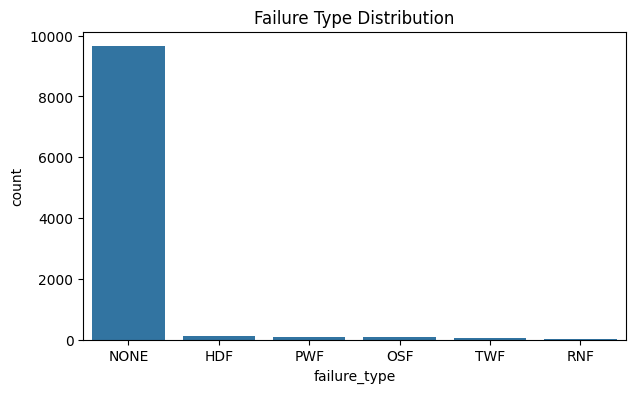

In [383]:
# class distribution
print(df['failure_type'].value_counts())
plt.figure(figsize=(7,4))
sns.countplot(x='failure_type', data=df, order=df['failure_type'].value_counts().index)
plt.title("Failure Type Distribution")
plt.show()

<Axes: >

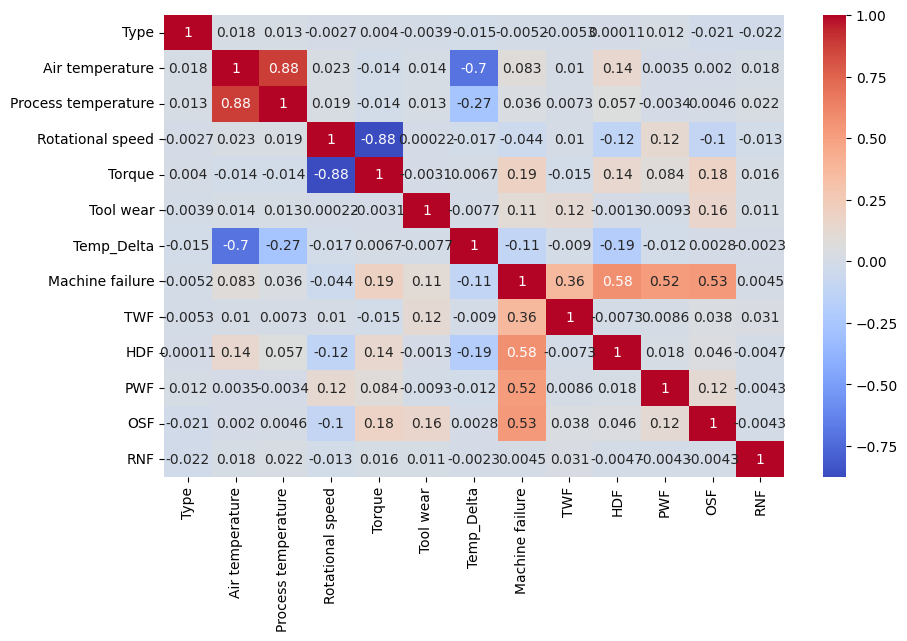

In [384]:
# Correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df.drop('failure_type', axis=1).corr(), annot=True, cmap='coolwarm')

In [385]:
df.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Temp_Delta,Machine failure,TWF,HDF,PWF,OSF,RNF,failure_type
0,2,298.1,308.6,1551,42.8,0,10.5,0,0,0,0,0,0,NONE
1,1,298.2,308.7,1408,46.3,3,10.5,0,0,0,0,0,0,NONE
2,1,298.1,308.5,1498,49.4,5,10.4,0,0,0,0,0,0,NONE
3,1,298.2,308.6,1433,39.5,7,10.4,0,0,0,0,0,0,NONE
4,1,298.2,308.7,1408,40.0,9,10.5,0,0,0,0,0,0,NONE


In [386]:
feature_candidates = ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear', 'Temp_Delta', 'Type']
df['Type'] = type_labeler.inverse_transform(df['Type'])

# Binary Classification: Random Forest

Create a binary classifier model to predict machine failure. This exercise serves as a reference point before attempting multiclass classification. 

In [387]:
# Final X, y prep
X_1 = df[feature_candidates].copy()
y_1 = df['Machine failure'].copy()

# Encode categorical 'Type' if present
cat_cols = [c for c in X_1.columns if X_1[c].dtype == 'object' or 'type' in c.lower()]
num_cols = [c for c in X_1.columns if c not in cat_cols]

print("Numerical features:", num_cols)
print("Categorical features:", cat_cols)


# Pipeline: preprocessing + classifier
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

if cat_cols:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
        ])
else:
    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, num_cols)]
    )

model = RandomForestClassifier(n_estimators=100, random_state=42)

pipe = Pipeline(steps=[('preproc', preprocessor), ('model', model)])

Numerical features: ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear', 'Temp_Delta']
Categorical features: ['Type']


In [388]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_1, y_1, test_size=0.2, random_state=42
)

# Fit baseline model
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.986
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.85      0.66      0.74        61

    accuracy                           0.99      2000
   macro avg       0.92      0.83      0.87      2000
weighted avg       0.99      0.99      0.99      2000

Confusion Matrix:
 [[1932    7]
 [  21   40]]


Torque                 0.294177
Rotational speed       0.257670
Temp_Delta             0.159693
Tool wear              0.139977
Air temperature        0.064930
Process temperature    0.057434
Type_L                 0.012237
Type_M                 0.008665
Type_H                 0.005218
dtype: float64


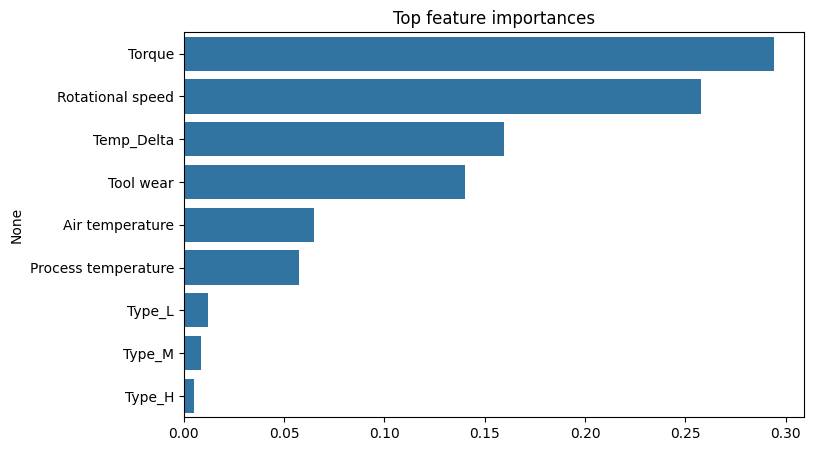

In [389]:
# Feature importance (global)
# Extract feature names after preprocessing
preproc = pipe.named_steps['preproc']
# numeric column names (after scaler) preserved; OneHotEncoder expands cats if present
num_features = num_cols
cat_features = []
if cat_cols:
    ohe = preproc.named_transformers_['cat']
    # build ohe feature names
    ohe_names = ohe.get_feature_names_out(cat_cols)
    cat_features = list(ohe_names)
all_features = list(num_features) + cat_features

rf_model = pipe.named_steps['model']
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)
print(feat_imp.head(10))

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title("Top feature importances")
plt.show()

In [390]:
# Reporting

MODEL_OUT = MODELS_DIR + "binary_model.joblib"
MODEL_METRICS_JSON = MODELS_DIR + "binary_model_report.json"

# Save model and artifacts
joblib.dump(pipe, MODEL_OUT)
print("Model saved to", MODEL_OUT)

# Export model metrics and feature importance
report = {
    'classification report': classification_report(y_test, y_pred, output_dict=True),
    'accuracy': pipe.score(X_test, y_test),
    'roc_auc': roc_auc_score(y_test, y_pred),
    'feature_importance': feat_imp.to_dict()
}
import json
with open(MODEL_METRICS_JSON, "w") as f:
    json.dump(report, f)
print("Metrics saved to", MODEL_METRICS_JSON)

# predicted results
results = pd.merge(X_1, y_1, left_index=True, right_index=True)
results['Predicted Failure'] = pipe.predict(X_1)
display(results.head())
# results.to_csv('./binary_model_predictions.csv')

Model saved to ./models/binary_model.joblib
Metrics saved to ./models/binary_model_report.json


,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Temp_Delta,Type,Machine failure,Predicted Failure
0,298.1,308.6,1551,42.8,0,10.5,M,0,0
1,298.2,308.7,1408,46.3,3,10.5,L,0,0
2,298.1,308.5,1498,49.4,5,10.4,L,0,0
3,298.2,308.6,1433,39.5,7,10.4,L,0,0
4,298.2,308.7,1408,40.0,9,10.5,L,0,0


# Multiclass Classification: Random Forest

In [391]:
# Final X, y prep
X_2 = df[feature_candidates].copy()
y_2 = df['failure_type'].copy()

# Encode categorical 'Type' if present
cat_cols = [c for c in X_2.columns if X_2[c].dtype == 'object' or 'type' in c.lower()]
num_cols = [c for c in X_2.columns if c not in cat_cols]

print("Numerical features:", num_cols)
print("Categorical features:", cat_cols)


# Pipeline: preprocessing + classifier
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

if cat_cols:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
        ])
else:
    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, num_cols)]
    )

clf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', clf)])

Numerical features: ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear', 'Temp_Delta']
Categorical features: ['Type']


In [392]:
# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_2, y_2, test_size=0.2, stratify=y_2, random_state=42
)

# Fit baseline model
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.985
              precision    recall  f1-score   support

         HDF       1.00      1.00      1.00        23
        NONE       0.99      1.00      0.99      1930
         OSF       1.00      0.50      0.67        16
         PWF       0.91      0.56      0.69        18
         RNF       0.00      0.00      0.00         4
         TWF       0.00      0.00      0.00         9

    accuracy                           0.98      2000
   macro avg       0.65      0.51      0.56      2000
weighted avg       0.98      0.98      0.98      2000



c:\Users\gvnin\Documents\projects\predictive-maintenance-dataset\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gvnin\Documents\projects\predictive-maintenance-dataset\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gvnin\Documents\projects\predictive-maintenance-dataset\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

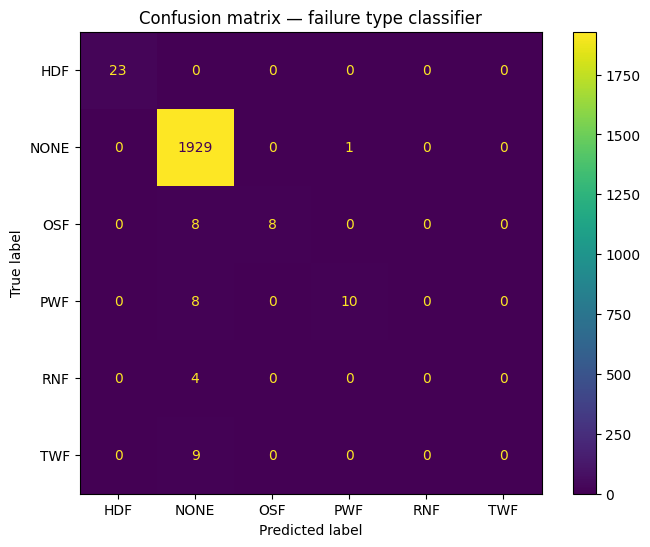

Macro F1: 0.5581009649496239


In [393]:
# Confusion matrix and per-class F1
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(ax=ax)
plt.title("Confusion matrix — failure type classifier")
plt.show()

# Macro F1 and (optional) multiclass ROC AUC - requires binarized labels
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1:", macro_f1)


In [394]:
# Multiclass ROC AUC (one-vs-rest)
from sklearn.preprocessing import label_binarize
classes = np.unique(y_2)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = pipe.predict_proba(X_test)  # RandomForest supports predict_proba

# if predict_proba shape matches classes:
try:
    auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
    print("Multiclass ROC AUC (macro, OVR):", auc_macro)
except Exception as e:
    print("Could not compute multiclass ROC AUC:", e)


Multiclass ROC AUC (macro, OVR): 0.8991659117210377


Torque                 0.242364
Tool wear              0.241960
Temp_Delta             0.171131
Rotational speed       0.168455
Air temperature        0.077132
Process temperature    0.072495
Type_L                 0.012343
Type_M                 0.008875
Type_H                 0.005245
dtype: float64


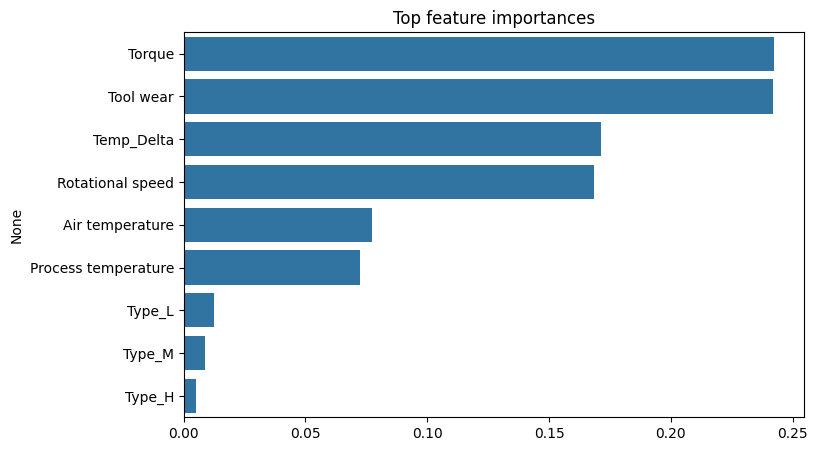

In [395]:
# Feature importance (global)
# Extract feature names after preprocessing
preproc = pipe.named_steps['preproc']
# numeric column names (after scaler) preserved; OneHotEncoder expands cats if present
num_features = num_cols
cat_features = []
if cat_cols:
    ohe = preproc.named_transformers_['cat']
    # build ohe feature names
    ohe_names = ohe.get_feature_names_out(cat_cols)
    cat_features = list(ohe_names)
all_features = list(num_features) + cat_features

rf_model = pipe.named_steps['clf']
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)
print(feat_imp.head(10))

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title("Top feature importances")
plt.show()


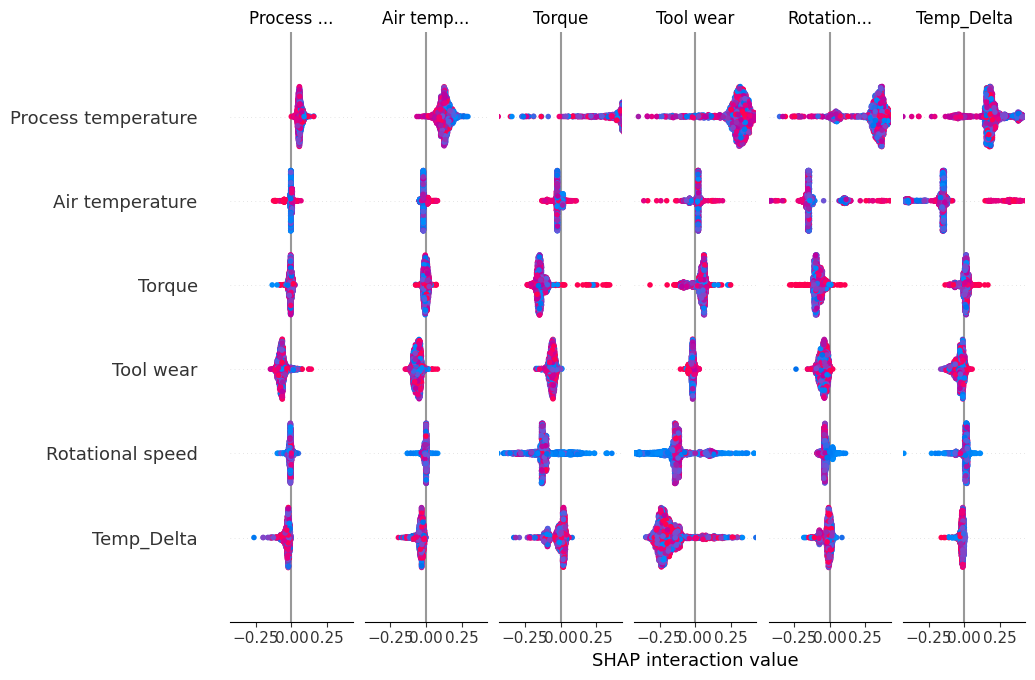

In [396]:
if HAS_SHAP:
    explainer = shap.TreeExplainer(rf_model)
    X_test_trans = preproc.transform(X_test)  # numeric array
    # shap expects original features; build DataFrame
    X_test_df = pd.DataFrame(X_test_trans, columns=all_features)
    shap_values = explainer.shap_values(X_test_df)
    # summary for first class
    shap.summary_plot(shap_values, X_test_df)


In [397]:
# Reporting

MODEL_OUT = MODELS_DIR + "multiclass_model.joblib"
MODEL_METRICS_JSON = MODELS_DIR + "multiclass_model_report.json"

# Save model and artifacts
joblib.dump(pipe, MODEL_OUT)
print("Model saved to", MODEL_OUT)

# Export model metrics and feature importance
report = {
    'classification report': classification_report(y_test, y_pred, output_dict=True),
    'accuracy': pipe.score(X_test, y_test),
    'Multiclass ROC AUC (macro, OVR)': auc_macro,
    'feature_importance': feat_imp.to_dict()
}
import json
with open(MODEL_METRICS_JSON, "w") as f:
    json.dump(report, f)
print("Model metrics saved to", MODEL_METRICS_JSON)

Model saved to ./models/multiclass_model.joblib
Model metrics saved to ./models/multiclass_model_report.json


c:\Users\gvnin\Documents\projects\predictive-maintenance-dataset\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gvnin\Documents\projects\predictive-maintenance-dataset\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gvnin\Documents\projects\predictive-maintenance-dataset\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [398]:
# Map predictions to simulated NCR dispositions (CSV)
disposition_map = {
    'TWF': 'Replace tool; open NCR; escalate to Tooling',
    'HDF': 'Investigate cooling; collect temp sensors; open NCR',
    'PWF': 'Check power supply logs; escalate to Supplier Quality',
    'OSF': 'Inspect mechanical stress; check torque logs; open NCR',
    'RNF': 'Manual inspection; rare random failure - capture trace'
}
# Apply to test set rows and save
predicted = pipe.predict(X_test)
out_df = X_test.copy()
out_df['true_failure'] = y_test.values
out_df['predicted_failure'] = predicted
out_df['recommended_disposition'] = out_df['predicted_failure'].map(disposition_map).fillna('Manual review')
out_df.to_csv("predicted_ncr_simulation.csv", index=False)
display(out_df.head())
print("Saved simulated dispositions to predicted_ncr_simulation.csv")


,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Temp_Delta,Type,true_failure,predicted_failure,recommended_disposition
1916,298.0,307.7,1387,50.8,204,9.7,L,NONE,NONE,Manual review
2928,300.8,309.7,1258,54.9,168,8.9,M,NONE,NONE,Manual review
1181,297.2,308.3,1379,52.1,21,11.1,L,NONE,NONE,Manual review
9840,298.3,309.2,1486,42.4,16,10.9,H,NONE,NONE,Manual review
647,297.7,309.3,1559,36.9,145,11.6,L,NONE,NONE,Manual review


Saved simulated dispositions to predicted_ncr_simulation.csv


# Additional

Estimate Remaining Useful Life 